# Poker AI Setup

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pokerenv.obs_indices as indices
from pokerenv.table import Table
from treys import Deck, Evaluator, Card
from pokerenv.common import GameState, PlayerState, PlayerAction, TablePosition, Action, action_list
from pokerenv.player import Player
from pokerenv.utils import pretty_print_hand, approx_gt, approx_lte
import types
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gym
import math
import time


## Create enviorment

In [68]:
class ModifiedTable(Table):
    def __init__(self, n_players, player_names=None, track_single_player=False, stack_low=50, stack_high=200, hand_history_location='hands/', invalid_action_penalty=0):
        super().__init__(n_players, player_names, track_single_player, stack_low, stack_high, hand_history_location, invalid_action_penalty)
        self.dealer_position = 0 
         
    def _int_to_str(card_int: int) -> str:
        rank_int = Card.get_rank_int(card_int)
        suit_int = Card.get_suit_int(card_int)
        return Card.STR_RANKS[rank_int] + Card.INT_SUIT_TO_CHAR_SUIT[suit_int]
    
    def _get_rank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 8) & 0xF
        else:
            return (card_int[0] >> 8) & 0xF
        
    def _get_suit_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 12) & 0xF
        else:
            return (card_int[0] >> 12) & 0xF
        
    def _get_bitrank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 16) & 0x1FFF
        else:
            return (card_int[0] >> 16) & 0x1FFF

    def _get_prime(card_int: int) -> int:
        if card_int is int:
            return card_int & 0x3F
        else:
            return card_int[0] & 0x3F

    def _street_transition(self, transition_to_end=False):
            transitioned = False
            if self.street == GameState.PREFLOP:
                self.cards = self.deck.draw(3)
                self._write_event("*** FLOP *** [%s %s %s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2])))
                self.street = GameState.FLOP
                transitioned = True
            if self.street == GameState.FLOP and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** TURN *** [%s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3])))
                self.street = GameState.TURN
                transitioned = True
            if self.street == GameState.TURN and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** RIVER *** [%s %s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3]),
                                Card.int_to_str(self.cards[4])))
                self.street = GameState.RIVER
                transitioned = True
            if self.street == GameState.RIVER and (not transitioned or transition_to_end):
                if not self.hand_is_over:
                    if self.hand_history_enabled:
                        self._write_show_down()
                self.hand_is_over = True
            self.street_finished = False
            self.last_bet_placed_by = None
            self.first_to_act = None
            self.bet_to_match = 0
            self.minimum_raise = 0
            for player in self.players:
                player.finish_street()

    def step(self, action: Action):
        BB = 5
        self.current_player_i = self.next_player_i
        player = self.players[self.current_player_i]
        self.current_turn += 1

        if (player.all_in or player.state is not PlayerState.ACTIVE) and not self.hand_is_over:
            raise Exception("A player who is inactive or all-in was allowed to act")
        if self.first_to_act is None:
            self.first_to_act = player

        # Apply the player action
        if not (self.hand_is_over or self.street_finished):
            valid_actions = self._get_valid_actions(player)
            if not self._is_action_valid(player, action, valid_actions):
                player.punish_invalid_action()
            elif action.action_type is PlayerAction.FOLD:
                player.fold()
                self.active_players -= 1
                self._write_event("%s: folds" % player.name)
            elif action.action_type is PlayerAction.CHECK:
                player.check()
                self._write_event("%s: checks" % player.name)
            elif action.action_type is PlayerAction.CALL:
                call_size = player.call(self.bet_to_match)
                self.pot += call_size
                if player.all_in:
                    self._write_event("%s: calls $%.2f and is all-in" % (player.name, call_size * BB))
                else:
                    self._write_event("%s: calls $%.2f" % (player.name, call_size * BB))
            elif action.action_type is PlayerAction.BET:
                previous_bet_this_street = player.bet_this_street
                actual_bet_size = player.bet(np.round(action.bet_amount, 2))
                self.pot += actual_bet_size
                if self.bet_to_match == 0:
                    if player.all_in:
                        self._write_event("%s: bets $%.2f and is all-in" % (player.name, actual_bet_size * BB))
                    else:
                        self._write_event("%s: bets $%.2f" % (player.name, actual_bet_size * BB))
                else:
                    if player.all_in:
                        self._write_event("%s: raises $%.2f to $%.2f and is all-in" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                    else:
                        self._write_event("%s: raises $%.2f to $%.2f" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                self._change_bet_to_match(actual_bet_size + previous_bet_this_street)
                self.last_bet_placed_by = player
            else:
                raise Exception("Error when parsing action, make sure player action_type is PlayerAction and not int")

            should_transition_to_end = False
            players_with_actions = [p for p in self.players if p.state is PlayerState.ACTIVE if not p.all_in]
            players_who_should_act = [p for p in players_with_actions if (not p.acted_this_street or p.bet_this_street != self.bet_to_match)]

            # If the game is over, or the betting street is finished, progress the game state
            if len(players_with_actions) < 2 and len(players_who_should_act) == 0:
                amount = 0
                # If all active players are all-in, transition to the end, allowing no actions in the remaining streets
                if self.active_players > 1:
                    biggest_bet_call = max(
                        [p.bet_this_street for p in self.players
                            if p.state is PlayerState.ACTIVE if p is not self.last_bet_placed_by]
                    )
                    last_bet_this_street = 0
                    if self.last_bet_placed_by is not None:
                        last_bet_this_street = self.last_bet_placed_by.bet_this_street
                    if biggest_bet_call < last_bet_this_street:
                        amount = last_bet_this_street - biggest_bet_call
                    should_transition_to_end = True
                # If everyone else has folded, end the hand
                else:
                    self.hand_is_over = True
                    amount = self.minimum_raise
                # If there are uncalled bets, return them to the player who placed them
                if amount > 0:
                    self.pot -= amount
                    self.last_bet_placed_by.stack += amount
                    self.last_bet_placed_by.money_in_pot -= amount
                    self.last_bet_placed_by.bet_this_street -= amount
                    self._write_event(
                        "Uncalled bet ($%.2f) returned to %s" % (amount * BB, self.last_bet_placed_by.name)
                    )
                if should_transition_to_end:
                    self._street_transition(transition_to_end=True)
            # If the betting street is still active, choose next player to act
            else:
                active_players_after = [i for i in range(self.n_players) if i > self.current_player_i if
                                        self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                active_players_before = [i for i in range(self.n_players) if i <= self.current_player_i if
                                            self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                if len(active_players_after) > 0:
                    self.next_player_i = min(active_players_after)
                else:
                    self.next_player_i = min(active_players_before)
                next_player = self.players[self.next_player_i]
                if self.last_bet_placed_by is next_player or (self.first_to_act is next_player and self.last_bet_placed_by is None):
                    self.street_finished = True
                    if len(active_players_before) > 0:
                        self.next_player_i = min(active_players_before)

        if self.street_finished and not self.hand_is_over:
            self._street_transition()

        obs = np.zeros(self.observation_space.shape[0]) if self.hand_is_over else self._get_observation(self.players[self.next_player_i])
        rewards = np.asarray([player.get_reward() for player in sorted(self.players)])
        if self.hand_is_over:
            self._distribute_pot()
            self._finish_hand()
            
        return obs, rewards, self.hand_is_over, {}
      
    def reset(self):
          """Override reset to properly rotate positions"""
          self.current_turn = 0
          self.pot = 0
          self.street = GameState.PREFLOP
          self.deck.cards = Deck.GetFullDeck()
          self.rng.shuffle(self.deck.cards)
          self.cards = []
          self.active_players = self.n_players
          
          # Rotate dealer position
          self.dealer_position = (self.dealer_position + 1) % self.n_players
          
          # Reset players
          for player in self.players:
              player.reset()
              
          # Assign new positions relative to dealer
          for i in range(self.n_players):
              position = (i + self.dealer_position) % self.n_players
              self.players[i].position = position
              self.players[i].stack = self.rng.integers(self.stack_low, self.stack_high, 1)[0]
              
          # Deal cards
          initial_draw = self.deck.draw(self.n_players * 2)
          for i, player in enumerate(self.players):
              player.cards = [initial_draw[i], initial_draw[i+self.n_players]]
              
          # Reset other game state
          self.hand_history = []
          if self.hand_history_enabled:
              self._history_initialize()
              
          # Post blinds
          self.next_player_i = 0 if self.n_players == 2 else 2
          self.current_player_i = self.next_player_i
          self.first_to_act = None
          self.street_finished = False
          self.hand_is_over = False
          
          for i, player in enumerate(self.players):
              if player.position == TablePosition.SB:
                  self.pot += player.bet(0.5)
                  self._change_bet_to_match(0.5)
                  self._write_event("%s: posts small blind $%.2f" % (player.name, SB))
              elif player.position == TablePosition.BB:
                  self.pot += player.bet(1)
                  self._change_bet_to_match(1)
                  self.last_bet_placed_by = player
                  self._write_event("%s: posts big blind $%.2f" % (player.name, BB))
                  
          if self.hand_history_enabled:
              self._write_hole_cards()
              
          return self._get_observation(self.players[self.next_player_i])

In [69]:
# Create the enviorment:
def createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player=False):
    table = ModifiedTable(active_players, 
                player_names=player_names,
                track_single_player=track_single_player,
                stack_low=low_stack_bbs,
                stack_high=high_stack_bbs,
                hand_history_location=hand_history_location,
                invalid_action_penalty=invalid_action_penalty
    )
    table.seed(1)
    return table
            

## Env Modifications

## Learning Loop

In [70]:
def learningLoop(table, agents, active_players, n_iterations, player_names):
    iteration = 1
    playerWinnings = [[0 for player in table.players]]
    winners = []
    position_stats = {i: {pos: 0 for pos in range(active_players)} for i in range(active_players)}

    while True:
        if iteration % 50 == 0:
            table.hand_history_enabled = True
        
        # Track positions every hand
        print(f"\nHand {iteration} positions:")
        for i, player in enumerate(table.players):
            print(f"Agent {i} ({player_names[i]}): Position {player.position}")
            
        table.n_players = active_players
        
        # Update position statistics
        for i, player in enumerate(table.players):
            position_stats[i][player.position] += 1
            
        for agent in agents:
            if hasattr(agent, "update_policy"):
                agent.update_policy(winners)
            agent.reset()
            
        obs = table.reset()
        winners = []
        acting_player = int(obs[indices.ACTING_PLAYER])
        
        while True:
            action = agents[acting_player].get_action(obs)
            obs, reward, done, _ = table.step(action)
            if done:
                # Distribute final rewards
                for i in range(active_players):
                    agents[i].rewards.append(reward[i])
                break
            else:
                agents[acting_player].rewards.append(reward[acting_player])
                acting_player = int(obs[indices.ACTING_PLAYER])
                
        iteration += 1
        playerWinnings.append([player.winnings for player in table.players])
        
        for agent, player in zip(agents, table.players):
            if player.winnings > 0:
                winners.append((agent, player))
                
        table.hand_history_enabled = False
        if iteration % 250 == 0:
            print(f"\nIteration: {iteration}")
        
        if iteration >= n_iterations:
            break
    
    # Print final position statistics
    print("\nPosition Statistics:")
    print("-" * 50)
    for i in range(active_players):
        print(f"\nAgent {i} ({player_names[i]}):")
        total_hands = sum(position_stats[i].values())
        for pos in range(active_players):
            count = position_stats[i][pos]
            percentage = (count / total_hands) * 100
            print(f"Position {pos}: {count} hands ({percentage:.1f}%)")
    
    return playerWinnings

# Agents

## Random Agent

In [6]:
# Agent that makes random actions
class RandomAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        chosen_action = PlayerAction(np.random.choice(valid_actions))
        bet_size = 0
        if chosen_action is PlayerAction.BET:
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Fold Agent

In [7]:
# Agent that always folds
class FoldAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Determined Agent

In [8]:
# Agent that never folds
class DeterminedAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.CALL
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Aggressive agent

In [9]:
# Agent that always raises
class AggressiveAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.BET
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, valid_bet_high)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    

## Chance agent

In [10]:
# Agent that uses encoded hand values to make decisions
class ValueAgent:
    def __init__(self, value_model):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.value_model = value_model

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        hand_value = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        bet_value = self.value_model.predict(np.array([[hand_value, pot_size]]))[0][0]
        
        if bet_value > 0.5:
            chosen_action = PlayerAction.BET
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        elif valid_bet_high == 0.0:
            chosen_action = PlayerAction.CALL
        else:
            chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Q-Learning Agent

In [11]:
class QLearningAgent:
    def __init__(self, eta=0.1, gamma=0.95, epsilon=0.1):
        self.q_table = {}  # Q-table to store state-action values
        self.eta = eta      # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        
        # Get valid actions
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        
        # Create a simplified state representation
        state = self._get_state_key(observation)

        # Initialize Q-values for new states
        if state not in self.q_table:
            self.q_table[state] = {action: 0.0 for action in valid_actions}

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            chosen_action = np.random.choice(valid_actions)
        else:
            # Choose action with highest Q-value among valid actions
            valid_q_values = {action: self.q_table[state].get(action, 0.0) 
                            for action in valid_actions}
            chosen_action = max(valid_q_values, key=valid_q_values.get)

        # Convert chosen action to PlayerAction enum
        chosen_action = PlayerAction(chosen_action)

        # Determine bet size if the action is BET
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        # Create the action object
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def _get_state_key(self, observation):
        """Create a simplified state representation for Q-table"""
        # Extract relevant features from observation
        player_stack = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        position = observation[indices.ACTING_PLAYER_POSITION]
        
        # Get card ranks (simplified)
        card1_rank = int(observation[9])  # First card rank
        card2_rank = int(observation[11]) # Second card rank
        
        # Create a tuple of important state features
        return (position, card1_rank, card2_rank, 
                int(player_stack/10),  # Discretize stack size
                int(pot_size/10))      # Discretize pot size
    
    def _get_reward(self, observation, winners):
        """Calculate reward based on the game state"""
        winning_agents = [agent for agent, player in winners]
        if self in winning_agents:
            return 1.0  # Won the hand
        return -1.0    # Lost the hand
    
    def update_policy(self, winners):
        # Update Q-values for each state-action pair in this episode
        for i in range(len(self.observations) - 1):  # -1 because we need a next state
            current_state = self._get_state_key(self.observations[i])
            next_state = self._get_state_key(self.observations[i + 1])
            action = self.actions[i]
            reward = self._get_reward(self.observations[i], winners)

            # If next_state is not in Q-table, initialize it
            if next_state not in self.q_table:
                valid_actions = np.argwhere(self.observations[i+1][indices.VALID_ACTIONS] == 1).flatten()
                self.q_table[next_state] = {action: 0.0 for action in valid_actions}

            # Get maximum Q-value for next state
            next_max = max(self.q_table[next_state].values()) if self.q_table[next_state] else 0

            # Update Q-value
            if current_state in self.q_table and action.action_type.value in self.q_table[current_state]:
                self.q_table[current_state][action.action_type.value] += self.eta * (
                    reward + self.gamma * next_max - self.q_table[current_state][action.action_type.value]
                )

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## REgression to RElative REward Based RL Agent

In [12]:
class REBELAgent:
    def __init__(self, eta=0.1):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.scaler = StandardScaler()
        self.regressor = SGDRegressor()  # Regression model for action-value scores
        self.eta = eta  # Learning rate for policy updates

        # Initialize regressor with dummy data
        dummy_X = np.zeros((1, 63))  # Replace 63 with the correct feature size
        dummy_y = [0]
        self.regressor.partial_fit(dummy_X, dummy_y)

    def get_action(self, observation):
        self.observations.append(observation)

        # Get valid actions
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_action_types = [action_list[i] for i in valid_actions]  # Map to PlayerAction

        # Compute scores for each valid action
        action_scores = []
        for action_type in valid_action_types:
            encoded_action = self._encode_action(observation, Action(action_type, 0))
            action_scores.append(self.regressor.predict([encoded_action])[0])

        # Apply softmax to compute probabilities
        action_probs = self._softmax(action_scores)

        # Sample an action based on probabilities
        chosen_action_idx = np.random.choice(len(valid_action_types), p=action_probs)
        chosen_action = valid_action_types[chosen_action_idx]  # Use PlayerAction enum

        # Determine bet size if the chosen action is a bet
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        table_action = Action(chosen_action, bet_size)  # Use PlayerAction
        self.actions.append(table_action)
        return table_action

    def _softmax(self, scores):
        exp_scores = np.exp(scores - np.max(scores))  # Subtract max for numerical stability
        return exp_scores / np.sum(exp_scores)

    def update_policy(self, winners):
        X = []
        y = []

        for obs, action in zip(self.observations, self.actions):
            action_features = self._encode_action(obs, action)
            reward = self._get_reward(obs, winners)
            X.append(action_features)
            y.append(reward)

        # Convert X to a numpy array and ensure it's 2D
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)  # Reshape to 2D if necessary

        # Handle case where X or y is empty
        if len(X) == 0 or len(y) == 0:
            return
        
        X = self.scaler.fit_transform(X)
        self.regressor.partial_fit(X, y)

    def _encode_action(self, observation, action):
        action_vector = np.zeros(len(action_list))
        action_vector[action.action_type.value] = 1  # Use the value of PlayerAction
        bet_feature = np.array([action.bet_amount])
        return np.concatenate([observation, action_vector, bet_feature])

    def _get_reward(self, observation, winners):
        if self in winners:
            return 1
        else:
            return 0

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []


# Run Throughs

## Rebel vs ineffective agents

In [13]:
active_players = 6
agents = [REBELAgent(), RandomAgent(), FoldAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [14]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


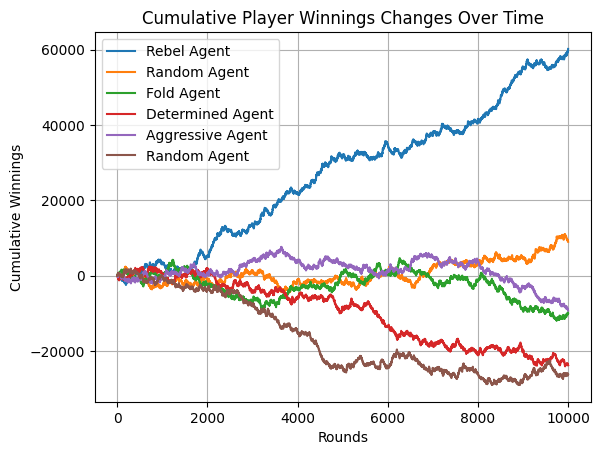

In [15]:
players = ["Rebel Agent", "Random Agent", "Fold Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebels vs 3 Random

In [16]:
active_players = 6
agents = [REBELAgent(), REBELAgent(), RandomAgent(), RandomAgent(), REBELAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [17]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


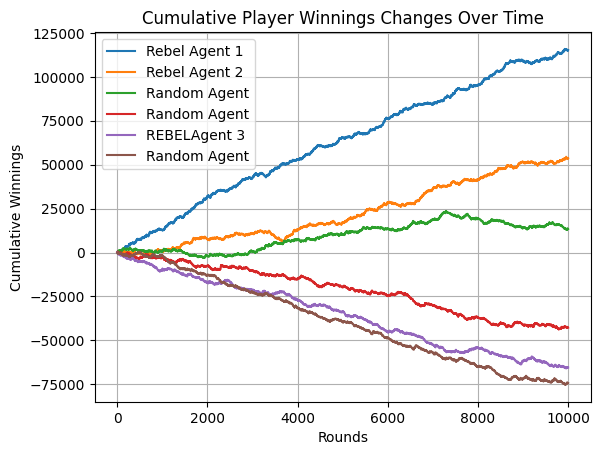

In [18]:
players = ["Rebel Agent 1", "Rebel Agent 2", "Random Agent", "Random Agent", "REBELAgent 3", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel 3 Q-Learning 2 Random

In [19]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), RandomAgent(), QLearningAgent(), RandomAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [20]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


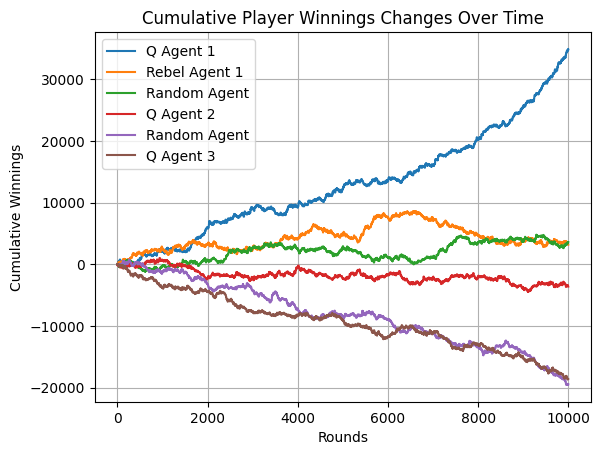

In [21]:
players = ["Q Agent 1", "Rebel Agent 1", "Random Agent", "Q Agent 2", "Random Agent", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebel vs 3 Q-Learning

In [22]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), REBELAgent(), QLearningAgent(), REBELAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [23]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


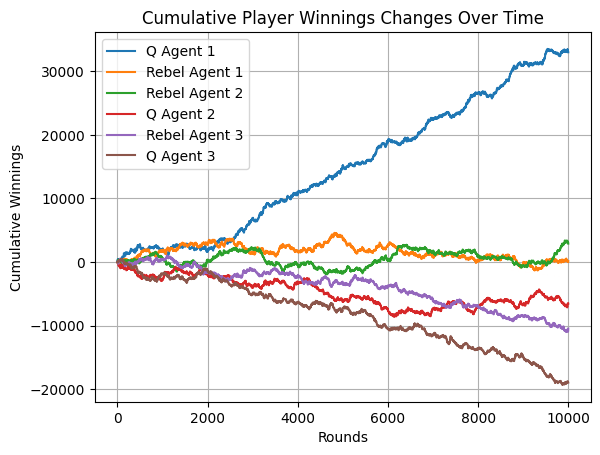

In [24]:
players = ["Q Agent 1", "Rebel Agent 1", "Rebel Agent 2", "Q Agent 2", "Rebel Agent 3", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel vs 5 Q-Learning

In [25]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [26]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


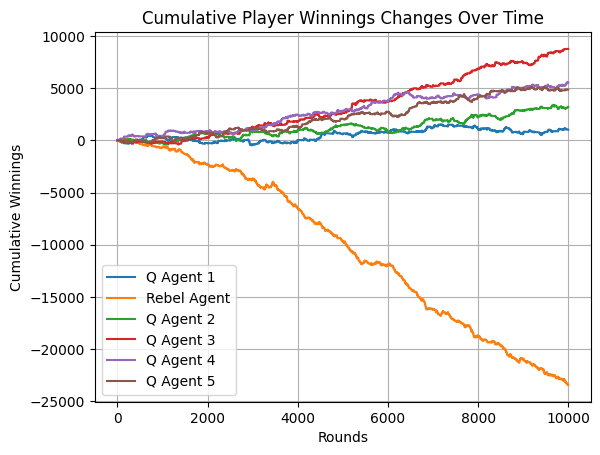

In [27]:
players = ["Q Agent 1", "Rebel Agent", "Q Agent 2", "Q Agent 3", "Q Agent 4", "Q Agent 5"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import numpy as np
from collections import defaultdict
import math
from pokerenv.common import PlayerAction, Action
import pokerenv.obs_indices as indices

class MCTSNode:
    def __init__(self, state=None, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value = 0.0
        self.untried_actions = None

class MCTSAgent:
    def __init__(self, c_param=1.414, n_simulations=50):
        self.c_param = c_param
        self.n_simulations = n_simulations
        self.actions = []
        self.observations = []
        self.rewards = []
        self.nodes = {}

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def _get_state_key(self, observation):
        """Create a simplified state representation"""
        position = int(observation[indices.ACTING_PLAYER_POSITION])
        stack = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot = observation[indices.POT_SIZE]
        
        # Include cards if available
        cards = []
        if observation[8] != 0:  # If cards exist
            cards = [
                (int(observation[8]), int(observation[9])),    # Card 1
                (int(observation[10]), int(observation[11]))   # Card 2
            ]
        
        return (position, int(stack/10), int(pot/10), tuple(cards))

    def _get_valid_actions(self, observation):
        """Get list of valid actions and their bet ranges"""
        valid_actions = []
        
        # Check each action individually
        for i in range(4):  # 4 possible actions
            if observation[1 + i] == 1:  # Valid actions start at index 1
                action = PlayerAction(i)
                if action == PlayerAction.BET:
                    bet_range = (observation[indices.VALID_BET_LOW], 
                               observation[indices.VALID_BET_HIGH])
                else:
                    bet_range = (0, 0)
                valid_actions.append((action, bet_range))
    
        return valid_actions

    def _select_node(self, node):
        """Select best child node using UCB1"""
        best_score = float('-inf')
        best_action = None
        best_child = None

        for action, child in node.children.items():
            exploit = child.value / (child.visits + 1e-6)
            explore = math.sqrt(2 * math.log(node.visits + 1) / (child.visits + 1e-6))
            ucb = exploit + self.c_param * explore

            if ucb > best_score:
                best_score = ucb
                best_action = action
                best_child = child

        return best_action, best_child

    def _expand_node(self, node, observation):
        """Create a new child node"""
        if node.untried_actions is None:
            node.untried_actions = self._get_valid_actions(observation)
        
        if not node.untried_actions:
            return None, None

        # Choose random untried action
        action_info = node.untried_actions.pop(0)
        action_type, bet_range = action_info
        
        # Create action
        bet_size = 0
        if action_type == PlayerAction.BET and bet_range[1] > 0:
            bet_size = np.random.uniform(bet_range[0], bet_range[1])
        action = Action(action_type, bet_size)
        
        # Create new node
        new_state = self._get_state_key(observation)
        new_node = MCTSNode(state=new_state, parent=node)
        node.children[action] = new_node
        
        return action, new_node

    def _simulate(self, observation):
        """Run a simple simulation"""
        sim_reward = 0
        valid_actions = self._get_valid_actions(observation)
        
        if not valid_actions:
            return 0
        
        # Simple heuristic-based reward
        action_type, bet_range = valid_actions[np.random.randint(len(valid_actions))]
        
        if action_type == PlayerAction.FOLD:
            sim_reward = -observation[indices.POT_SIZE] * 0.5
        elif action_type == PlayerAction.CHECK:
            sim_reward = 0.1
        elif action_type == PlayerAction.CALL:
            sim_reward = -observation[indices.POT_SIZE] * 0.1
        elif action_type == PlayerAction.BET:
            pot_odds = observation[indices.POT_SIZE] / (bet_range[0] + 1e-6)
            sim_reward = 0.2 * pot_odds
            
        return sim_reward

    def _backpropagate(self, node, reward):
        """Update node statistics"""
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def get_action(self, observation):
        """Select best action using MCTS"""
        self.observations.append(observation)
        state = self._get_state_key(observation)
        
        if state not in self.nodes:
            self.nodes[state] = MCTSNode(state=state)
        root = self.nodes[state]
        
        # Run simulations
        for _ in range(self.n_simulations):
            node = root
            sim_obs = observation.copy()
            
            # Selection
            action = None
            while node.untried_actions is None or not node.untried_actions:
                if not node.children:
                    break
                action, node = self._select_node(node)
                if node is None:
                    break
            
            # Expansion
            if node is not None and (node.untried_actions is None or node.untried_actions):
                action, node = self._expand_node(node, sim_obs)
            
            # Simulation
            reward = self._simulate(sim_obs)
            
            # Backpropagation
            if node is not None:
                self._backpropagate(node, reward)
        
        # Choose best action
        best_action = None
        best_value = float('-inf')
        
        for action, child in root.children.items():
            value = child.value / (child.visits + 1e-6)
            if value > best_value:
                best_value = value
                best_action = action
        
        # Fallback to random action if needed
        if best_action is None:
            valid_actions = self._get_valid_actions(observation)
            action_type, bet_range = valid_actions[np.random.randint(len(valid_actions))]
            bet_size = 0
            if action_type == PlayerAction.BET and bet_range[1] > 0:
                bet_size = np.random.uniform(bet_range[0], bet_range[1])
            best_action = Action(action_type, bet_size)
        
        self.actions.append(best_action)
        return best_action

In [54]:
import numpy as np
from collections import defaultdict
from pokerenv.common import PlayerAction, Action
import pokerenv.obs_indices as indices

class CFRAgent:
    def __init__(self):
        self.regret_sum = defaultdict(lambda: np.zeros(4))  # 4 possible actions
        self.strategy_sum = defaultdict(lambda: np.zeros(4))
        self.actions = []
        self.observations = []
        self.rewards = []
        
    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    def _get_info_set(self, observation):
        """Create a key for the current information set"""
        position = int(observation[indices.ACTING_PLAYER_POSITION])
        pot = observation[indices.POT_SIZE]
        street = observation[15]  # Game street
        
        # Get hole cards
        card1 = (int(observation[8]), int(observation[9]))    # (suit, rank)
        card2 = (int(observation[10]), int(observation[11]))  # (suit, rank)
        
        # Get community cards
        community = []
        for i in range(5):
            if observation[16 + i*2] != 0:
                suit = int(observation[16 + i*2])
                rank = int(observation[17 + i*2])
                community.append((suit, rank))
                
        return (position, int(pot/10), street, card1, card2, tuple(community))
        
    def get_strategy(self, info_set):
        """Get current strategy for this information set"""
        regret = self.regret_sum[info_set]
        normalized = np.maximum(regret, 0)
        sum_positive = np.sum(normalized)
        
        if sum_positive > 0:
            return normalized / sum_positive
        return np.ones(4) / 4  # Default to uniform strategy
        
    def _get_valid_actions(self, observation):
        """Get list of valid actions from observation"""
        valid_actions = []
        # Check each action index directly (1 through 4)
        for i in range(4):
            if observation[1 + i] == 1:  # Valid actions start at index 1
                valid_actions.append(i)
        return valid_actions
        
    def get_action(self, observation):
        """Choose action based on current strategy"""
        self.observations.append(observation)
        info_set = self._get_info_set(observation)
        strategy = self.get_strategy(info_set)
        
        # Get valid actions
        valid_actions = self._get_valid_actions(observation)
                
        # Filter strategy to only valid actions
        valid_probs = np.zeros(4)
        for action in valid_actions:
            valid_probs[action] = strategy[action]
            
        # Normalize probabilities
        sum_probs = np.sum(valid_probs)
        if sum_probs > 0:
            valid_probs /= sum_probs
        else:
            # If all probabilities are zero, use uniform distribution over valid actions
            for action in valid_actions:
                valid_probs[action] = 1.0 / len(valid_actions)
        
        # Choose action
        action_type = PlayerAction(np.random.choice(4, p=valid_probs))
        bet_size = 0
        
        if action_type == PlayerAction.BET:
            bet_size = np.random.uniform(
                observation[indices.VALID_BET_LOW],
                observation[indices.VALID_BET_HIGH]
            )
            
        action = Action(action_type, bet_size)
        self.actions.append(action)
        return action
        
    def update_regret(self, info_set, action, reward, other_action_values):
        """Update regret values"""
        for a in range(4):
            if a == action.action_type.value:
                regret = reward - other_action_values[a]
            else:
                regret = other_action_values[a] - reward
            self.regret_sum[info_set][a] += regret
            
    def update_strategy(self, info_set, strategy):
        """Update strategy sum for averaging"""
        self.strategy_sum[info_set] += strategy

In [71]:
# Test setup
active_players = 4
agents = [
    MCTSAgent(c_param=1.414, n_simulations=50),  # MCTS agent
    RandomAgent(),                               # Random agent for comparison
    QLearningAgent(),                           # Your Q-Learning agent
    CFRAgent()                                  # CFR agent
]

player_names = {
    0: 'MCTS',
    1: 'Random',
    2: 'QLearn',
    3: 'CFR'
}

# Create environment and run test
table = createEnviorment(
    active_players, 
    agents, 
    player_names, 
    low_stack_bbs, 
    high_stack_bbs, 
    hand_history_location, 
    invalid_action_penalty, 
    track_single_player=False
)
table.seed(42)

# Run simulation
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations, player_names)

# Print results
print("\nResults:")
print("-" * 40)
winnings_array = np.array(player_winnings)

for i in range(active_players):
    total_winnings = np.sum(winnings_array[:, i])
    avg_winnings = np.mean(winnings_array[:, i])
    print(f"{player_names[i]}:")
    print(f"Total winnings: {total_winnings:.2f}")
    print(f"Average winnings per hand: {avg_winnings:.2f}")
    print("-" * 40)


Hand 1 positions:
Agent 0 (MCTS): Position 0
Agent 1 (Random): Position 0
Agent 2 (QLearn): Position 0
Agent 3 (CFR): Position 0


AttributeError: 'ModifiedTable' object has no attribute 'dealer_position'

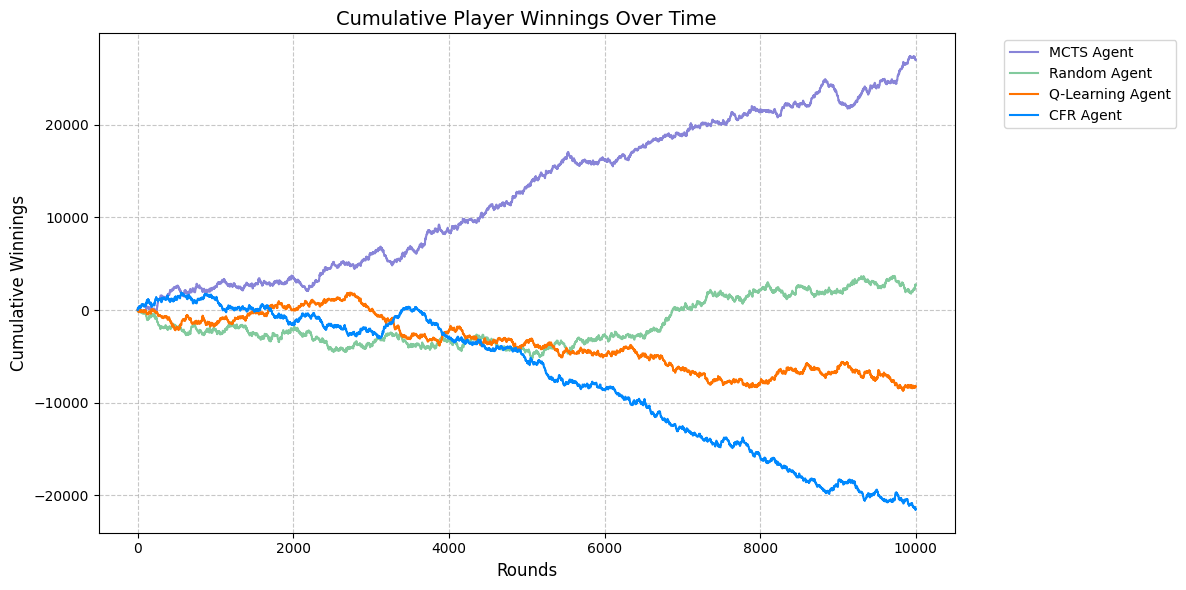

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_winnings(player_winnings, player_names):
    # Compute the running cumulative sum for each player
    cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

    # Transpose to get stacks per player
    cumulative_player_stacks_transposed = cumulative_player_stacks.T

    # Create figure with a larger size
    plt.figure(figsize=(12, 6))

    # Plot cumulative stacks for each player
    colors = ['#8884d8', '#82ca9d', '#ff7300', '#0088fe']  # Match the React colors
    for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed):
        plt.plot(cumulative_stack, label=player_names[i], color=colors[i])

    # Add labels and legend
    plt.xlabel('Rounds', fontsize=12)
    plt.ylabel('Cumulative Winnings', fontsize=12)
    plt.title('Cumulative Player Winnings Over Time', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage after your MCTS test:
player_names = ['MCTS Agent', 'Random Agent', 'Q-Learning Agent', 'CFR Agent']
plot = plot_cumulative_winnings(player_winnings, player_names)
plot.show()

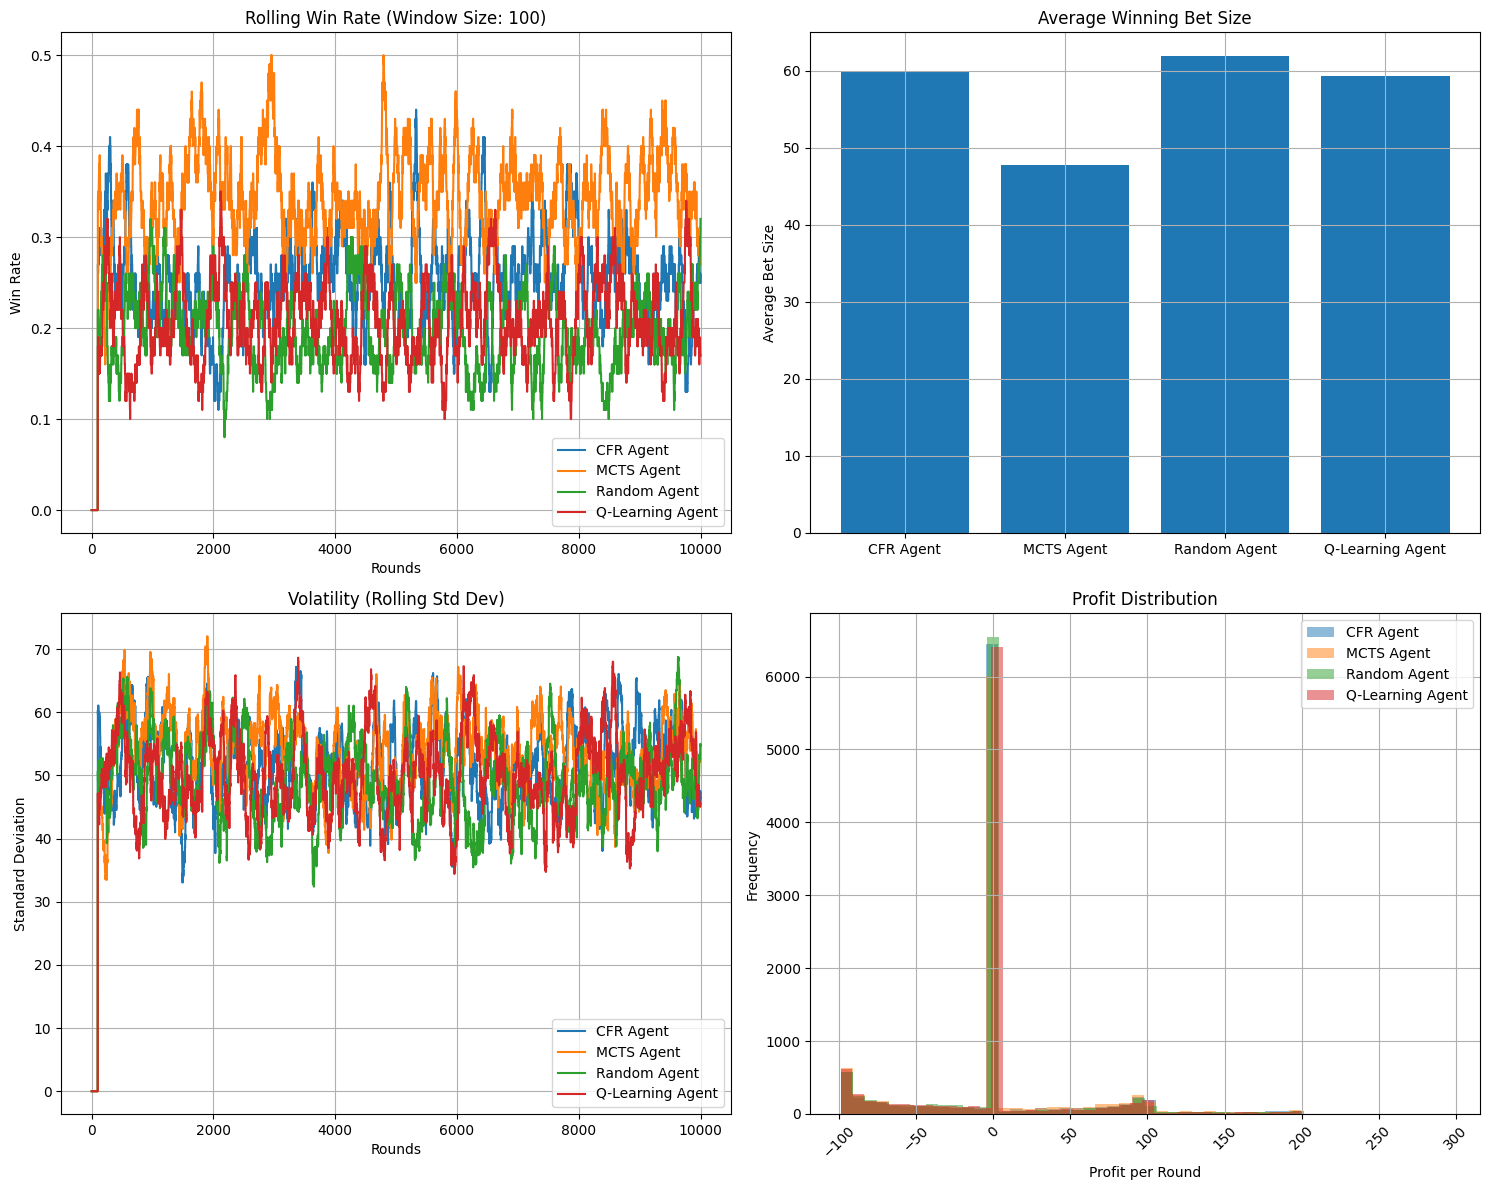

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_metrics(player_winnings, player_names, window_size=100):
    # Create a figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Win Rate Over Time
    wins = (np.array(player_winnings) > 0).astype(int)
    win_rates = np.zeros((len(player_winnings), len(player_names)))
    
    for i in range(len(player_winnings)):
        if i >= window_size:
            win_rates[i] = np.mean(wins[i-window_size:i], axis=0)
    
    for i in range(len(player_names)):
        ax1.plot(win_rates[:,i], label=player_names[i])
    ax1.set_title('Rolling Win Rate (Window Size: {})'.format(window_size))
    ax1.set_xlabel('Rounds')
    ax1.set_ylabel('Win Rate')
    ax1.grid(True)
    ax1.legend()

    # 2. Average Bet Sizes (when betting)
    bet_sizes = []
    for player_idx in range(len(player_names)):
        player_bets = [win for win in player_winnings if win[player_idx] > 0]
        if player_bets:
            bet_sizes.append(np.mean([bet[player_idx] for bet in player_bets]))
        else:
            bet_sizes.append(0)
    
    ax2.bar(player_names, bet_sizes)
    ax2.set_title('Average Winning Bet Size')
    ax2.set_ylabel('Average Bet Size')
    plt.xticks(rotation=45)
    ax2.grid(True)

    # 3. Volatility (Rolling Standard Deviation)
    volatility = np.zeros((len(player_winnings), len(player_names)))
    for i in range(len(player_winnings)):
        if i >= window_size:
            volatility[i] = np.std(player_winnings[i-window_size:i], axis=0)
    
    for i in range(len(player_names)):
        ax3.plot(volatility[:,i], label=player_names[i])
    ax3.set_title('Volatility (Rolling Std Dev)')
    ax3.set_xlabel('Rounds')
    ax3.set_ylabel('Standard Deviation')
    ax3.grid(True)
    ax3.legend()

    # 4. Profit per Round Distribution
    for i, name in enumerate(player_names):
        profits = [win[i] for win in player_winnings]
        ax4.hist(profits, bins=50, alpha=0.5, label=name)
    ax4.set_title('Profit Distribution')
    ax4.set_xlabel('Profit per Round')
    ax4.set_ylabel('Frequency')
    ax4.grid(True)
    ax4.legend()

    plt.tight_layout()
    return plt

# Example usage:
plot_performance_metrics(player_winnings, player_names)
plt.show()